# Data Mining Lab 3
#### Team 2:  Patricia Goresen, Jeffrey Lancon, Brychan Manry, George C Sturrock

## Business Understanding I
The source of baseball data for this lab is the Sean Lahman Baseball Database [ http://www.seanlahman.com/baseball-archive/statistics/]. Often cited as the most complete baseball database, the data set includes twenty-seven data tables and millions of records covering most non-proprietary baseball data pertaining to offense, fielding, pitching, payroll, player demographics, team statistics, manager data and much more.  

In previous assignments, the team focused on predicting MLB team playoff appearances, using team level data, and predicting player positions, using on field player statistics.  

For this Lab, we will use unsupervised clustering techniques, to gain insight into MLB pitcher’s statistics, in an attempt to discover statistics and/or patterns that differentiate pitchers from one another. 


###### How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?
In Lab 3, the team will focus on ??? tasks.  First, the team will employ different clustering techniques, to determine the optimal clustering technique and parameters which best fit the dataset.  Second, 

A full list of variables and their meanings are provided in *Data Description* section of this notebook.

## Data Understanding - Part 1

This lab will focus on the analysis of five specific tables containing player level details in the Lahman Baseball Database:  Batting, Fielding, Pitching, Salaries, and People.  The names of the different tables accurately describe the contents.  For example, the Batting table contains offensive statics per year for each player.  The tables are at different grains.  The ultimate intention is to have a single data frame accurately combining all relevant features of the four tables.  The methods used to achieve this goal will be presented below.  

In addition to the Lahman’s datasets, two additional datasets will be merged into the final dataset, MinSalary.csv and Inflation.csv.  The MinSalary.csv is a listing of minimum salaries for MLB players by year.  The Inflation.csv is a salary inflation index from 1985 to 2017 that was created using CPI data courtesy of Minneapolis Federal Reserve.

### Import Data

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns

batting = pd.read_csv('./data/Batting.csv')
fielding = pd.read_csv('./data/Fielding.csv')
salaries = pd.read_csv('./data/Salaries.csv')
inflation = pd.read_csv('./data/Inflation.csv')
minSalary = pd.read_csv('./data/MinimumSalaries.csv')
pitching = pd.read_csv('./data/PitchingIn.csv')
people = pd.read_csv('./data/People.csv')

#Rename Column Names to standardize with Lahman database columns and remove spaces
inflation = inflation.rename(index=str, columns={'Year': 'yearID'})
minSalary = minSalary.rename(index=str, columns={'Year': 'yearID', 'MinSalaries ': 'MinSalaries'})

#print('Batting', batting.info())
#print('Fielding', fielding.info())
#print('Salaries', salaries.info())
#print('Inflation', inflation.info())
#print('Minimum Salary', minSalary.info())
#print('Pitching', PitchingIn.info())

In [53]:
## Go back and convert to table ##
#teamNullCols = pd.DataFrame({'n Missing' : teamNullCols, '% Missing' : ((teamNullCols / teams2.shape[0])*100).round(2)#.astype(str) + "%"})

print("Shape of DataFrames:", "\nBatting:", batting.shape, "\nFielding:", fielding.shape, "\nSalaries:", salaries.shape, "\nInflation:", inflation.shape, "\nMinimum Salary:", minSalary.shape, "\nPitching:", pitching.shape)

Shape of DataFrames: 
Batting: (104324, 24) 
Fielding: (138838, 18) 
Salaries: (26428, 5) 
Inflation: (33, 4) 
Minimum Salary: (51, 2) 
Pitching: (45806, 30)


### Subsetting by Year

As evident from the difference in data frame sizes displayed above, a one to one match does not exist between the four major and two minor source tables. The process of creating data frames which can be merged into a single data frame will begin with row level filtering. Only records from the 1985 season and greater will be used for analysis in this assignment. 1985 was chosen for two reasons.  

a)	MLB Salary data only goes back to 1985.  
b)	The evolution of the game and it players have changed quite a bit since beginning of professional baseball. Selecting only records from the 1985 season and forward provides a 32-year data set while eliminating data that would likely lead to erroneous results.

In [54]:
#awards = awards[awards.yearID > 1984]
batting = batting[batting.yearID > 1984]
fielding = fielding[fielding.yearID > 1984]
salaries = salaries[salaries.yearID > 1984]
minSalary = minSalary[minSalary.yearID > 1984]
pitching = pitching[pitching.yearID > 1984]

print("Shape of DataFrames:", "\nBatting:", batting.shape, "\nFielding:", fielding.shape, "\nSalaries:", salaries.shape, "\nInflation:", inflation.shape, "\nMinimum Salary:", minSalary.shape, "\nPitching:", pitching.shape)

Shape of DataFrames: 
Batting: (42071, 24) 
Fielding: (54560, 18) 
Salaries: (26428, 5) 
Inflation: (33, 4) 
Minimum Salary: (33, 2) 
Pitching: (20822, 30)


### Batting

The Batting table will be the driver for the overall consolidated data frame.  In other words, fielding, salaries and awards will be merged into the Batting data frame.  First, categorical variables such as Team and League ID which offer limited predictive or structural value will be dropped from the data frame.  The 'G_old' variable is the void of values and will be dropped as well.

In [55]:
batting = batting.drop(['teamID', 'lgID', 'G_old', 'G_batting', 'stint'], axis=1)
#Drop rows with no basic statistics are recorded in a year
#batting = batting[(batting[['AB', 'BB']] != 0).all(axis=1)]
batting = batting[(batting[['AB']] != 0).all(axis=1)]
batting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30823 entries, 1 to 104305
Data columns (total 19 columns):
playerID    30823 non-null object
yearID      30823 non-null int64
G           30823 non-null int64
AB          30823 non-null int64
R           30823 non-null int64
H           30823 non-null int64
2B          30823 non-null int64
3B          30823 non-null int64
HR          30823 non-null int64
RBI         30823 non-null float64
SB          30823 non-null float64
CS          30823 non-null float64
BB          30823 non-null int64
SO          30823 non-null float64
IBB         30823 non-null float64
HBP         30823 non-null float64
SH          30823 non-null float64
SF          30823 non-null float64
GIDP        30823 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.7+ MB


There are approximately 1,800 instances where a player has more than one record per year in the batting data frame.  This is to be expected as player trades and multiple stints in the major league do occur in a single season.  These instances will be consolidated into a single row per 'playerID'. 

In [56]:
#Identify Instances where a player has more than one batting record per year.
df = batting.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]
#print(df)

#Consolidate and Aggreagate
#print(batting.groupby(['yearID', 'playerID']).sum().reset_index())
battingFinal = batting.groupby(['yearID', 'playerID']).sum().reset_index()

#print(battingFinal)
print('  BattingFinal Info\n')
print(battingFinal.info())

print('\n\n   BattingFinal Statistics\n')
battingFinal.describe().round(2)

  BattingFinal Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28904 entries, 0 to 28903
Data columns (total 19 columns):
yearID      28904 non-null int64
playerID    28904 non-null object
G           28904 non-null int64
AB          28904 non-null int64
R           28904 non-null int64
H           28904 non-null int64
2B          28904 non-null int64
3B          28904 non-null int64
HR          28904 non-null int64
RBI         28904 non-null float64
SB          28904 non-null float64
CS          28904 non-null float64
BB          28904 non-null int64
SO          28904 non-null float64
IBB         28904 non-null float64
HBP         28904 non-null float64
SH          28904 non-null float64
SF          28904 non-null float64
GIDP        28904 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.2+ MB
None


   BattingFinal Statistics



,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,28904.0,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00,28904.00
mean,2001.9,64.41,179.44,23.96,46.88,9.03,1.01,5.23,22.71,3.40,1.46,17.25,34.58,1.40,1.61,1.74,1.48,4.03
std,9.3,49.93,199.23,30.29,56.41,11.48,1.89,8.56,29.92,7.71,2.73,23.20,38.02,3.18,2.86,2.80,2.23,5.31
min,1985.0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1994.0,22.00,11.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00
50%,2002.0,48.00,77.00,8.00,17.00,3.00,0.00,1.00,7.00,0.00,0.00,6.00,20.00,0.00,0.00,0.00,0.00,1.00
75%,2010.0,108.00,328.00,41.00,84.00,16.00,1.00,7.00,38.00,3.00,2.00,28.00,56.00,1.00,2.00,2.00,2.00,7.00
max,2017.0,163.00,716.00,152.00,262.00,59.00,23.00,73.00,165.00,110.00,29.00,232.00,223.00,120.00,35.00,39.00,17.00,35.00


After consolidating duplicate entries, 28,904 unique records with 19 variable remain.

In [57]:
print("Index:", battingFinal.index)
print("\nColumns:")
battingFinal.columns

Index: RangeIndex(start=0, stop=28904, step=1)

Columns:


Index(['yearID', 'playerID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')

### Fielding
The Fielding table contains most of the common defensive statistics in baseball.  The granularity of this data set is by player, year, stint and position.  It is commonplace for players to play more than one position over the course of a season (year).  However, most players have a primary position in which they play a majority of the time.  There is also the concept of a utility player.  This a player who has no primary position and plays a significant number of games in many positions.  The end objective is to produce a final fielding data set summarized at the player and year granularity.

In [58]:
#fielding = fielding[fielding.POS != 'P']
print('  Fielding Info\n')
fielding.info()
print('\n\n   Fielding Statistics\n')
fielding.describe().round(2)

  Fielding Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54560 entries, 0 to 138837
Data columns (total 18 columns):
playerID    54560 non-null object
yearID      54560 non-null int64
stint       54560 non-null int64
teamID      54560 non-null object
lgID        54560 non-null object
POS         54560 non-null object
G           54560 non-null int64
GS          54545 non-null float64
InnOuts     54545 non-null float64
PO          54560 non-null int64
A           54560 non-null int64
E           54560 non-null float64
DP          54560 non-null int64
PB          3651 non-null float64
WP          0 non-null float64
SB          3651 non-null float64
CS          3651 non-null float64
ZR          0 non-null float64
dtypes: float64(8), int64(6), object(4)
memory usage: 7.9+ MB


   Fielding Statistics



,yearID,stint,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
count,54560.00,54560.00,54560.00,54545.00,54545.00,54560.00,54560.00,54560.00,54560.00,3651.00,0.0,3651.00,3651.00,0.0
mean,2002.05,1.08,35.47,25.02,670.33,74.49,28.64,1.89,6.91,3.07,NaN,26.91,11.55,NaN
std,9.42,0.29,40.09,39.60,1035.11,175.18,71.38,3.56,19.55,3.56,NaN,26.72,12.35,NaN
min,1985.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN
25%,1994.00,1.00,6.00,0.00,55.00,2.00,1.00,0.00,0.00,0.00,NaN,4.00,1.00,NaN
50%,2002.00,1.00,20.00,6.00,202.00,8.00,5.00,0.00,1.00,2.00,NaN,19.00,8.00,NaN
75%,2010.00,1.00,50.00,31.00,667.00,55.00,18.00,2.00,3.00,5.00,NaN,43.00,18.00,NaN
max,2017.00,4.00,163.00,162.00,4388.00,1597.00,570.00,42.00,176.00,35.00,NaN,155.00,89.00,NaN


From the above fielding data frame statistics, it's easy to see WP (wild pitch) and ZR (zone rating) variables are missing values in their entirety.  The two columns will be dropped from the data frame.  To maintain consistency with the batting data frame, team and league will be dropped as well.  

In [59]:
fielding = fielding.drop(['teamID', 'lgID', 'WP', 'ZR'], axis=1)

There are numerous missing values in the 'PB', 'SB' and 'CS' columns.  This does make sense as these are statistics specific to catchers. Example: 'CS' - times player caught opponent stealing.  

The data was spot checked to verify these are accurate missing values.  The missing values will be replaced with zeros.

In [60]:
fielding.fillna(value={'PB': 0, 'SB': 0, 'ZR': 0, 'CS': 0}, inplace = True)
#print(fielding.info())
print('   Fielding Statistics\n')
fielding.describe().round(2)

   Fielding Statistics



,yearID,stint,G,GS,InnOuts,PO,A,E,DP,PB,SB,CS
count,54560.00,54560.00,54560.00,54545.00,54545.00,54560.00,54560.00,54560.00,54560.00,54560.00,54560.00,54560.00
mean,2002.05,1.08,35.47,25.02,670.33,74.49,28.64,1.89,6.91,0.21,1.80,0.77
std,9.42,0.29,40.09,39.60,1035.11,175.18,71.38,3.56,19.55,1.20,9.64,4.30
min,1985.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1994.00,1.00,6.00,0.00,55.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,2002.00,1.00,20.00,6.00,202.00,8.00,5.00,0.00,1.00,0.00,0.00,0.00
75%,2010.00,1.00,50.00,31.00,667.00,55.00,18.00,2.00,3.00,0.00,0.00,0.00
max,2017.00,4.00,163.00,162.00,4388.00,1597.00,570.00,42.00,176.00,35.00,155.00,89.00


There were some 9772 instances where a player played multiple positions in the same year. These multiple position player's stats will be merge into a single observation per player per year. 

In [61]:
#Identify Players who played multiple positions per year.
df = fielding.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.stint > 1]
#print(df)
print(df.shape)

(9772, 14)


An important step of data cleansing, aggregation and merging process is to identify the primary position for each player.  If a player played multiple positions within a year, the Primary Position 'primePOS', for analysis purposes, will be the position at which the player played the most games.

In [62]:
#Identify Primary Postion per Player per Year Based on Max Games at a position.
df = fielding.groupby(['playerID', 'yearID', 'POS']).sum().reset_index()
df = df.groupby(['playerID', 'yearID', 'POS'])['G'].max().reset_index()
#df = df.groupby(['playerID', 'yearID', 'POS']).max()['G']
df = df.sort_values(by=['playerID', 'yearID', 'G'], ascending=[True, True, False])
#print(df)
#print(df.describe())

primePOS = pd.DataFrame()
svPlayerID = ''
svYearID = 0

for index, row in df.iterrows():
    #print (row["playerID"], row["yearID"], row['POS'], row['G'])
    if (svPlayerID != row['playerID'] or svYearID != row['yearID']):
        primePOS = primePOS.append({'playerID': row['playerID'], 'yearID': row['yearID'], 'Primary': row['POS']}, ignore_index=True)
        #print(svPlayerID, row["playerID"], svYearID, row["yearID"], row['POS'], row['G'])
        svPlayerID = row['playerID']
        svYearID = row['yearID']
    else:
        continue
  

In [63]:
print(primePOS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38453 entries, 0 to 38452
Data columns (total 3 columns):
Primary     38453 non-null object
playerID    38453 non-null object
yearID      38453 non-null float64
dtypes: float64(1), object(2)
memory usage: 901.3+ KB
None


After consolidating multiple position player's yearly stats, 38,453 unique records with 14 variable remain in the Fielding data frame.

In [64]:
#Condense Fielding Dataframe into one row per player per year.
fielding = fielding.groupby(['playerID', 'yearID']).sum().reset_index()

#Merge Primary Position into condensed Fielding data frame
fieldingFinal = pd.merge(fielding, primePOS, on=['playerID', 'yearID'], how='left')

#print(fieldingFinal)
#print(fieldingFinal.describe())
print('  FieldingFinal Info\n')
print(fieldingFinal.info())
print('\n\n   FieldingFinal Statistics')
fieldingFinal.describe().round(2)

  FieldingFinal Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38453 entries, 0 to 38452
Data columns (total 14 columns):
playerID    38453 non-null object
yearID      38453 non-null object
stint       38453 non-null int64
G           38453 non-null int64
GS          38447 non-null float64
InnOuts     38447 non-null float64
PO          38453 non-null int64
A           38453 non-null int64
E           38453 non-null float64
DP          38453 non-null int64
PB          38453 non-null float64
SB          38453 non-null float64
CS          38453 non-null float64
Primary     38453 non-null object
dtypes: float64(6), int64(5), object(3)
memory usage: 4.4+ MB
None


   FieldingFinal Statistics


,stint,G,GS,InnOuts,PO,A,E,DP,PB,SB,CS
count,38453.00,38453.00,38447.00,38447.00,38453.00,38453.00,38453.00,38453.00,38453.00,38453.00,38453.00
mean,1.53,50.32,35.49,951.01,105.69,40.64,2.68,9.81,0.29,2.55,1.10
std,1.21,45.21,46.26,1210.43,207.30,87.09,4.32,23.57,1.43,11.52,5.14
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,14.00,0.00,114.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,34.00,14.00,337.00,11.00,8.00,1.00,1.00,0.00,0.00,0.00
75%,2.00,73.00,52.00,1408.00,123.00,26.00,3.00,4.00,0.00,0.00,0.00
max,23.00,195.00,163.00,4388.00,1597.00,570.00,42.00,176.00,35.00,155.00,89.00


### Salaries

The Salaries data set contains yearly salaries for players beginning in 1985.  This data will be consolidated into one observation per player per year, similar to the fielding and batting data sets.  League and teamID will be dropped from this data set as well.
There are numerous salary entries missing.  These missing values will be addressed.

In [65]:
#Drop League and Team
salaries = salaries.drop(['teamID', 'lgID'], axis=1)

#Summarize salaries at the year and player level
salariesFinal = salaries.groupby(['playerID', 'yearID']).sum().reset_index()

#print(salariesFinal)
print('\n\n  SalariesFinal Statistics')
salariesFinal.describe().round(2)



  SalariesFinal Statistics


,yearID,salary
count,26323.00,26323.00
mean,2000.90,2093953.45
std,8.91,3460182.39
min,1985.00,0.00
25%,1994.00,300000.00
50%,2001.00,554391.00
75%,2009.00,2362500.00
max,2016.00,33000000.00


### People
The People table contains demographic data about players.  For this study, physical characteristics such as height, weight, throwing hand and batting hand may be of interest in the analysis.

In [66]:
people = people[['playerID', 'weight', 'height', 'bats', 'throws']]
print('  People Info\n')
people.info()

  People Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 5 columns):
playerID    19370 non-null object
weight      18533 non-null float64
height      18615 non-null float64
bats        18185 non-null object
throws      18391 non-null object
dtypes: float64(2), object(3)
memory usage: 756.7+ KB


### Merging Batting, Fielding, Salaries and People

The Batting, Fielding, Salaries and People data sets will be consolidated using playerID and yearID as indexes.  The Player data set will be created which will contain all the merged data sets.

In [67]:
#Merge Batting and Fielding
#Uncomment below if player dataframe needs to be deleted prior to rerunning a merge
#del player

player = pd.merge(battingFinal, fieldingFinal, on=['playerID', 'yearID'], how='left')

#Drop Pitchers from merged dataframe
player = player[player.Primary != 'P']

#Merge Salaries
player = pd.merge(player, salariesFinal, on=['playerID', 'yearID'], how='left')

#Merge People
player = pd.merge(player, people, on=['playerID'], how='left')

#print(player)
print('  Player Info - Post Batting/Fielding Merge\n')
print(player.info())
print('\n\n   Player Statistics - Post Batting/Fielding Merge')
player.describe().round(2)

  Player Info - Post Batting/Fielding Merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 36 columns):
yearID      19820 non-null object
playerID    19820 non-null object
G_x         19820 non-null int64
AB          19820 non-null int64
R           19820 non-null int64
H           19820 non-null int64
2B          19820 non-null int64
3B          19820 non-null int64
HR          19820 non-null int64
RBI         19820 non-null float64
SB_x        19820 non-null float64
CS_x        19820 non-null float64
BB          19820 non-null int64
SO          19820 non-null float64
IBB         19820 non-null float64
HBP         19820 non-null float64
SH          19820 non-null float64
SF          19820 non-null float64
GIDP        19820 non-null float64
stint       19536 non-null float64
G_y         19536 non-null float64
GS          19532 non-null float64
InnOuts     19532 non-null float64
PO          19536 non-null float64
A           19536 non-nu

,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,PO,A,E,DP,PB,SB_y,CS_y,salary,weight,height
count,19820.00,19820.00,19820.00,19820.00,19820.0,19820.00,19820.00,19820.00,19820.00,19820.00,...,19536.00,19536.00,19536.00,19536.00,19536.00,19536.00,19536.00,13683.00,19820.00,19820.00
mean,80.33,253.70,34.49,67.25,13.0,1.46,7.59,32.69,4.95,2.12,...,203.73,70.97,4.65,18.63,0.57,5.03,2.16,2261094.58,195.99,72.68
std,51.67,200.25,31.37,57.56,11.9,2.13,9.44,31.41,8.89,3.07,...,254.99,113.86,5.28,30.56,1.97,15.78,7.05,3688277.47,21.83,2.11
min,1.00,1.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,140.00,66.00
25%,30.00,64.75,7.00,14.00,2.0,0.00,1.00,6.00,0.00,0.00,...,37.00,3.00,1.00,1.00,0.00,0.00,0.00,300000.00,180.00,71.00
50%,82.00,215.00,25.00,53.00,10.0,1.00,4.00,23.00,1.00,1.00,...,120.00,14.00,3.00,3.00,0.00,0.00,0.00,625000.00,195.00,73.00
75%,129.00,432.00,57.00,114.00,21.0,2.00,11.00,52.00,6.00,3.00,...,259.00,80.00,7.00,22.00,0.00,0.00,0.00,2525000.00,210.00,74.00
max,163.00,716.00,152.00,262.00,59.0,23.00,73.00,165.00,110.00,29.00,...,1597.00,570.00,42.00,176.00,35.00,155.00,89.00,33000000.00,320.00,80.00


### Merge Inflation and Minimum Salary Data with Player DataFrame

In [68]:
player = pd.merge(player, inflation, on=['yearID'], how='left')
player = pd.merge(player, minSalary, on=['yearID'], how='left')

print('  Player Info - Post Inflation/minSalary Merge\n')
print(player.info())
print('\n\n   Player Statistics - Post Inflation/minSalary Merge')
player.describe().round(2)
#print(list(player))

  Player Info - Post Inflation/minSalary Merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 40 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-

,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,DP,PB,SB_y,CS_y,salary,weight,height,Annual Average,Mult2017,MinSalaries
count,19820.00,19820.00,19820.00,19820.00,19820.0,19820.00,19820.00,19820.00,19820.00,19820.00,...,19536.00,19536.00,19536.00,19536.00,13683.00,19820.00,19820.00,19820.00,19820.00,19820.00
mean,80.33,253.70,34.49,67.25,13.0,1.46,7.59,32.69,4.95,2.12,...,18.63,0.57,5.03,2.16,2261094.58,195.99,72.68,541.25,1.44,263269.65
std,51.67,200.25,31.37,57.56,11.9,2.13,9.44,31.41,8.89,3.07,...,30.56,1.97,15.78,7.05,3688277.47,21.83,2.11,125.67,0.37,160399.76
min,1.00,1.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,140.00,66.00,323.20,1.00,60000.00
25%,30.00,64.75,7.00,14.00,2.0,0.00,1.00,6.00,0.00,0.00,...,1.00,0.00,0.00,0.00,300000.00,180.00,71.00,434.10,1.12,109000.00
50%,82.00,215.00,25.00,53.00,10.0,1.00,4.00,23.00,1.00,1.00,...,3.00,0.00,0.00,0.00,625000.00,195.00,73.00,540.50,1.36,200000.00
75%,129.00,432.00,57.00,114.00,21.0,2.00,11.00,52.00,6.00,3.00,...,22.00,0.00,0.00,0.00,2525000.00,210.00,74.00,655.30,1.70,400000.00
max,163.00,716.00,152.00,262.00,59.0,23.00,73.00,165.00,110.00,29.00,...,176.00,35.00,155.00,89.00,33000000.00,320.00,80.00,736.60,2.28,535000.00


### Uniqueness

A review of the number of unique values per column shown below show little evidence there are issues with low or near zero variance.  Attributes with relatively low uniqueness counts such as bats, throws, triple (3B), stint and minimum salary per year for MLB players (MinSalaries) are to be expected.  

In [69]:
df = player.nunique(dropna = False)
print(df)

yearID                   33
playerID               3497
G_x                     163
AB                      694
R                       146
H                       231
2B                       59
3B                       23
HR                       65
RBI                     157
SB_x                     81
CS_x                     29
BB                      148
SO                      206
IBB                      43
HBP                      33
SH                       29
SF                       18
GIDP                     34
stint                    22
G_y                     189
GS                      165
InnOuts                4198
PO                     1270
A                       525
E                        40
DP                      160
PB                       28
SB_y                    130
CS_y                     65
Primary                   7
salary                 2359
weight                   96
height                   15
bats                      3
throws              

### Missing Values

Missing values per columns are summarized in the table shown below.  Many of these attributes result from merging the batting data frame with the fielding data frame.  These missing values have been spot checked at appear to be valid.  It is common to have a player not record any fielding statistics during a season.  
For example, every game played in an American League stadium will have two designated hitters in the starting lineup.  These players typically hit for their team's pitcher and do not have to play in the field.  Additionally, the National League employs the double switch as a strategy.  This can also lead to players hitting without fielding.  There are a variety of additional scenarios which could lead to this as well.  The missing values for each column will be evaluated and handled individually.
 

In [70]:
df = player.isnull().sum()
df = df[df > 0]
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / player.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

,% Missing,n Missing
stint,1.43,284
G_y,1.43,284
GS,1.45,288
InnOuts,1.45,288
PO,1.43,284
A,1.43,284
E,1.43,284
DP,1.43,284
PB,1.43,284
SB_y,1.43,284


#### Filling Missing Values

Stint will be filled with 1 when missing.  The remaining columns with high rates of missing values will be filled with zeros as these are instances where the player did not field a position or information was unavailable.  Salary will be filled with zeros in this step, but will receive additional treatment below.

In [71]:
colls = []
colls = ['G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'SB_y', 'CS_y', 'salary']


for c in colls:
    player[c].fillna(0, inplace=True)
    
#Fill missing stint with 1
player['stint'].fillna(1, inplace = True)
    
#Fill missing Primary Position with "DH"
player['Primary'].fillna('DH', inplace = True)

##### Missing Salary 

In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  Looking up individual contracts details for each player with a missing salary would be counterproductive.  These instances were filled with zero in the step above.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values.  

In [72]:
#Inflation Adjusted Salary
player['adjSalary'] = (player.salary * player.Mult2017)
player['adjMinSalaries'] = (player.MinSalaries * player.Mult2017)

player['adjSalary2'] = np.where(player['adjSalary'] == 0, player['adjMinSalaries'], player['adjSalary'])


print('  Player Info - Post Missing Value Adjustments\n')
print(player.info())
print('\n\n  Player Data Set - Post Missing Value Adjustments')
player.head()

  Player Info - Post Missing Value Adjustments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 43 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-

,yearID,playerID,G_x,AB,R,H,2B,3B,HR,RBI,...,height,bats,throws,Annual Average,AnnualPercentChange,Mult2017,MinSalaries,adjSalary,adjMinSalaries,adjSalary2
0,1985,adamsri02,54,121,12,23,3,1,2,10.0,...,74.0,R,R,323.2,3.50%,2.279,60000.0,0.0,136740.0,136740.0
1,1985,aguaylu01,91,165,27,46,7,3,6,21.0,...,69.0,R,R,323.2,3.50%,2.279,60000.0,540123.0,136740.0,540123.0
2,1985,aikenwi01,12,20,2,4,1,0,1,5.0,...,75.0,L,R,323.2,3.50%,2.279,60000.0,0.0,136740.0,136740.0
3,1985,allenga01,14,34,2,4,1,0,0,3.0,...,71.0,R,R,323.2,3.50%,2.279,60000.0,0.0,136740.0,136740.0
4,1985,almonbi01,88,244,33,66,17,0,6,29.0,...,75.0,R,R,323.2,3.50%,2.279,60000.0,581145.0,136740.0,581145.0


#### Final Check for Missing Values

A final check to see if any variables have missing values.

In [73]:
print(player.isnull().sum())

yearID                 0
playerID               0
G_x                    0
AB                     0
R                      0
H                      0
2B                     0
3B                     0
HR                     0
RBI                    0
SB_x                   0
CS_x                   0
BB                     0
SO                     0
IBB                    0
HBP                    0
SH                     0
SF                     0
GIDP                   0
stint                  0
G_y                    0
GS                     0
InnOuts                0
PO                     0
A                      0
E                      0
DP                     0
PB                     0
SB_y                   0
CS_y                   0
Primary                0
salary                 0
weight                 0
height                 0
bats                   0
throws                 0
Annual Average         0
AnnualPercentChange    0
Mult2017               0
MinSalaries            0


#### Subset by Number of Games to Reduce Outliers

As shown in the box plot below, the interquartile bottom limit for games played from the batting data is 30.  This value will be used to subset the data and reduce noise in the data set.  It is common for players to be called up from the minor leagues and/or optioned down to the minor leagues during the year.  These players, with very short stints, often play multiple positions or no position and their yearly statistics are not representative of a full-time player.  MLB player's union has a minimum of 43 games-played for a player to qualify for the union pension plan, so 30 was deemed to be an appropriate minimum number of games.

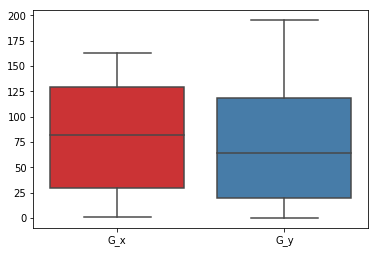

In [23]:
sns.boxplot(data=player[['G_x', 'G_y']], palette="Set1")

### New Variables

Baseball statistics often reference stats that are a combination of basic field stats: Batting Average 'Bavg', Slugging 'Slug', On-base-percentage 'OBP',...
While these stats are based on stats already included in our data set, it was decided to include these additional variables, as there may be some additional information garnered from these particular combinations.

In [74]:
#Batting Average
player['Bavg'] = (player.H / player.AB)

#Slugging
player['Slug'] = ((player.H - player['2B'] - player['3B'] - player.HR) + (player['2B']*2) + (player['3B']*3) + player.HR*4) / player.AB

#OBP
player['OBP'] = (player.H + player.BB + player.HBP) / (player.AB + player.BB + player.HBP + player.SF)

#Fielding Percentage - the sum of putouts and assists divided by the number of total chances (putouts + assists + errors)
player['FPct'] = (player.PO + player.A) / (player.PO + player.A + player.E)
player['FPct'].fillna(0, inplace = True)


### Player Data Set - Final Version

The final version of the Player data set consist of 19,820 observations and 46 variables

In [75]:
print(player.info())
print('\n\n  Player Data Set - Final')
player.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 47 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nu

,yearID,playerID,G_x,AB,R,H,2B,3B,HR,RBI,...,AnnualPercentChange,Mult2017,MinSalaries,adjSalary,adjMinSalaries,adjSalary2,Bavg,Slug,OBP,FPct
0,1985,adamsri02,54,121,12,23,3,1,2,10.0,...,3.50%,2.279,60000.0,0.0,136740.0,136740.0,0.190083,0.280992,0.228346,0.964539
1,1985,aguaylu01,91,165,27,46,7,3,6,21.0,...,3.50%,2.279,60000.0,540123.0,136740.0,540123.0,0.278788,0.466667,0.377551,0.965251
2,1985,aikenwi01,12,20,2,4,1,0,1,5.0,...,3.50%,2.279,60000.0,0.0,136740.0,136740.0,0.200000,0.400000,0.291667,0.000000
3,1985,allenga01,14,34,2,4,1,0,0,3.0,...,3.50%,2.279,60000.0,0.0,136740.0,136740.0,0.117647,0.147059,0.117647,1.000000
4,1985,almonbi01,88,244,33,66,17,0,6,29.0,...,3.50%,2.279,60000.0,581145.0,136740.0,581145.0,0.270492,0.413934,0.329630,0.976959


### Pitching Data Set

Pitching data set will stand separate from the position "player" data set.  Pitchers are evaluated and measured on different metrics and statistics when compared to position players; therefore, analysis of pitcher data should be distinct from position players.

The original Pitching Data set has a total of 20,822 observations and 30 variables.

Similar to the batting table, more than one record per player may exist in a year.  This could be due to being called up from or sent down to the minor leagues during the year, injuries, or trades.  There are 1,643 instances where a player has more than one stint/record per year in the Lahman database.  These multiple stats observation per year will be merged into a single observation per pitcher per year.   

In [76]:
#Identify Instances where a player has more than one batting record per year.
df = pitching.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]

print('Orignal Pitching Data Set Dimensions',pitching.shape)

print('\nInstances of Multiple records per year:',df.shape)

Orignal Pitching Data Set Dimensions (20822, 30)

Instances of Multiple records per year: (1643, 30)


An important step of data cleansing, aggregation and merging process is to identify pitchers with multiple records within a given year.  These multiple observation will be merged into a single observation per pitcher per year.

The aggregated Pitcher's data set contains 19,188 observations and 30 variables

In [77]:
#Consolidate and Aggreagate
#print(pitching.groupby(['yearID', 'playerID']).sum().reset_index())
pitching = pitching.groupby(['yearID', 'playerID']).sum().reset_index()

#print(pitching)
print(' Pitching Data Set Dims - Post Duplicate Cleansing',pitching.shape)
#print(pitching.info())
print('\n Pitcher Statistics - Post Duplicate Cleansing')
pitching.describe().round(2)

 Pitching Data Set Dims - Post Duplicate Cleansing (19118, 28)

 Pitcher Statistics - Post Duplicate Cleansing


,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,...,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19118.00,19116.00
mean,2002.60,1.18,3.97,3.97,28.34,7.93,0.46,0.15,2.00,212.59,...,2.12,2.59,2.43,0.37,304.71,7.47,36.23,2.63,2.24,6.09
std,9.34,0.62,4.56,3.97,21.17,11.57,1.44,0.54,6.82,194.83,...,2.37,2.88,2.79,0.89,273.36,12.02,32.15,3.03,2.33,6.30
min,1985.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1995.00,1.00,0.00,1.00,10.00,0.00,0.00,0.00,0.00,56.00,...,0.00,0.00,0.00,0.00,85.00,0.00,12.00,0.00,0.00,1.00
50%,2003.00,1.00,2.00,3.00,26.00,0.00,0.00,0.00,0.00,160.00,...,1.00,2.00,2.00,0.00,231.00,2.00,25.00,2.00,2.00,4.00
75%,2011.00,1.00,6.00,6.00,40.00,14.00,0.00,0.00,0.00,292.75,...,3.00,4.00,4.00,0.00,421.00,10.00,53.00,4.00,3.00,9.00
max,2017.00,10.00,27.00,21.00,94.00,40.00,24.00,10.00,62.00,881.00,...,20.00,26.00,21.00,16.00,1231.00,79.00,160.00,22.00,17.00,41.00


#### Merge People and Salary with Pitching

As was done with the Player data set, People and Salaries data sets will be merged to the Pitching data set.

In [78]:
#Merge People table with Pitching.
pitching = pd.merge(pitching, people, on=['playerID'], how='left')

#Merge Salary data table with Pitching
pitching = pd.merge(pitching, salariesFinal, on=['yearID', 'playerID'], how='left')
pitching = pd.merge(pitching, inflation, on=['yearID'], how='left')
pitching = pd.merge(pitching, minSalary, on=['yearID'], how='left')

##Drop and Rename Pitching Columns after merging
#pitching = pitching.drop(['yearID_y'], axis=1)
#pitching = pitching.rename(index=str, columns={'yearID_x': 'yearID'})

print(' Pitching Data Set Dims - Post People/Salary Merge',pitching.shape)
print('\n Pitcher Statistics - Post People/Salary Merge')
pitching.head().round(2)

 Pitching Data Set Dims - Post People/Salary Merge (19118, 37)

 Pitcher Statistics - Post People/Salary Merge


,yearID,playerID,stint,W,L,G,GS,CG,SHO,SV,...,GIDP,weight,height,bats,throws,salary,Annual Average,AnnualPercentChange,Mult2017,MinSalaries
0,1985,aasedo01,1,10,6,54,0,0,0,14,...,13.0,190.0,75.0,R,R,NaN,323.2,3.50%,2.28,60000.0
1,1985,abregjo01,1,1,1,6,5,0,0,0,...,3.0,185.0,72.0,R,R,NaN,323.2,3.50%,2.28,60000.0
2,1985,ackerji01,1,7,2,61,0,0,0,10,...,16.0,210.0,74.0,R,R,170000.0,323.2,3.50%,2.28,60000.0
3,1985,agostju01,1,4,3,54,0,0,0,1,...,4.0,190.0,74.0,L,L,147500.0,323.2,3.50%,2.28,60000.0
4,1985,aguilri01,1,10,7,21,19,2,0,0,...,8.0,195.0,76.0,R,R,NaN,323.2,3.50%,2.28,60000.0


### Minimum Games Pitched - Outlier Reduction

A minimum games played rule of 30 games per year is defined for the position player data frame.  A similar rule will be implemented for pitchers.  From a biomechanical perspective, the pitching motion is incredibly stressful on a pitcher's arm and shoulder.  As such, pitchers typically play far fewer games per year than position players.  For example, a starting pitcher typically plays once every five games.  A middle reliever could play every other game.  The box plot below shows the 1st interquartile range is 10 games.  This will be implemented as the minimum number of games rule for pitchers.

count    19118.00
mean        28.34
std         21.17
min          1.00
25%         10.00
50%         26.00
75%         40.00
max         94.00
Name: G, dtype: float64

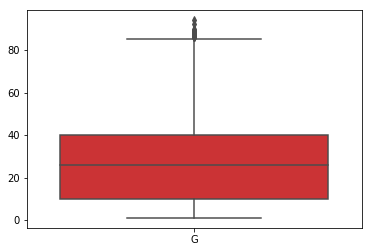

In [29]:
sns.boxplot(data=pitching[['G']], palette="Set1")
pitching.G.describe().round(2)

After the minimum games pitched rule is implemented, there are 14,473 records in the pitching data set.  

In [79]:
pitching = pitching[pitching.G > 9]
print(' Pitching Data Set Dims - Post Min Game Rule',pitching.shape)
print('\n Pitcher Statistics - Post Min Game Rule')
pitching.describe().round(2)

 Pitching Data Set Dims - Post Min Game Rule (14473, 37)

 Pitcher Statistics - Post Min Game Rule


,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,R,SH,SF,GIDP,weight,height,salary,Annual Average,Mult2017,MinSalaries
count,14473.00,14473.00,14473.00,14473.00,14473.00,14473.00,14473.00,14473.00,14473.00,14473.00,...,14473.00,14473.00,14473.00,14471.00,14473.00,14473.00,10684.00,14473.00,14473.00,14473.00
mean,2002.48,1.22,5.10,4.98,35.97,9.98,0.60,0.19,2.63,269.54,...,45.10,3.33,2.80,7.71,204.53,74.42,2008882.44,554.47,1.41,279595.65
std,9.33,0.68,4.69,4.02,18.72,12.56,1.63,0.61,7.74,190.80,...,31.97,3.15,2.38,6.40,22.65,2.12,3236706.17,124.10,0.36,160837.24
min,1985.00,1.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,10.00,...,0.00,0.00,0.00,0.00,150.00,66.00,60000.00,323.20,1.00,60000.00
25%,1995.00,1.00,1.00,2.00,21.00,0.00,0.00,0.00,0.00,127.00,...,20.00,1.00,1.00,3.00,190.00,73.00,303500.00,457.90,1.09,109000.00
50%,2003.00,1.00,4.00,4.00,32.00,1.00,0.00,0.00,0.00,207.00,...,34.00,2.00,2.00,6.00,200.00,74.00,600000.00,552.80,1.33,300000.00
75%,2011.00,1.00,8.00,8.00,49.00,21.00,0.00,0.00,1.00,390.00,...,69.00,5.00,4.00,11.00,220.00,76.00,2350000.00,676.00,1.61,414000.00
max,2017.00,10.00,27.00,21.00,94.00,40.00,24.00,10.00,62.00,881.00,...,160.00,22.00,17.00,41.00,315.00,83.00,33000000.00,736.60,2.28,535000.00


### Missing Values

Missing values per columns are summarized in the table shown below.  Twenty six percent of the salary information is missing from the data set. As previously stated, salary information for players not on a major league team's roster at the beginning of the year are not included in the Lahman database.  Missing salary data will be handled in the same manner as the player's data set.

In [80]:
df = pitching.isnull().sum()
df = df[df > 0]
print(df)
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / pitching.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

BAOpp        2
GIDP         2
salary    3789
dtype: int64


,% Missing,n Missing
BAOpp,0.01,2
GIDP,0.01,2
salary,26.18,3789


##### Missing Salary 

In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values. 

In [81]:
#Fill missing values with 0.  
pitching['salary'].fillna(0, inplace=True)

#Inflation Adjusted Salary
pitching['adjSalary'] = (pitching.salary * pitching.Mult2017)
pitching['adjMinSalaries'] = (pitching.MinSalaries * pitching.Mult2017)

pitching['adjSalary2'] = np.where(pitching['adjSalary'] == 0, pitching['adjMinSalaries'], pitching['adjSalary'])

print('  Pitching Shape - Post Missing Value Adjustments\n',pitching.shape)
print('\n\n  Pitching Data Set - Post Missing Value Adjustments')
pitching.head()

  Pitching Shape - Post Missing Value Adjustments
 (14473, 40)


  Pitching Data Set - Post Missing Value Adjustments


,yearID,playerID,stint,W,L,G,GS,CG,SHO,SV,...,bats,throws,salary,Annual Average,AnnualPercentChange,Mult2017,MinSalaries,adjSalary,adjMinSalaries,adjSalary2
0,1985,aasedo01,1,10,6,54,0,0,0,14,...,R,R,0.0,323.2,3.50%,2.279,60000.0,0.0,136740.0,136740.0
2,1985,ackerji01,1,7,2,61,0,0,0,10,...,R,R,170000.0,323.2,3.50%,2.279,60000.0,387430.0,136740.0,387430.0
3,1985,agostju01,1,4,3,54,0,0,0,1,...,L,L,147500.0,323.2,3.50%,2.279,60000.0,336152.5,136740.0,336152.5
4,1985,aguilri01,1,10,7,21,19,2,0,0,...,R,R,0.0,323.2,3.50%,2.279,60000.0,0.0,136740.0,136740.0
5,1985,alexado01,1,17,10,36,36,6,1,0,...,R,R,875000.0,323.2,3.50%,2.279,60000.0,1994125.0,136740.0,1994125.0


### Uniqueness

The table below shown there is little concern for attributes with near zero variance.  Stint is expected to have little variance as it is rare for a pitcher to have more than two stints per year.  Four stints in a season is the maximum observed in the remaining data.  People attributes such as bats and throws should have a low number of unique values.

In [82]:
df = pitching.nunique(dropna = False)
df

yearID                   33
playerID               3168
stint                     4
W                        26
L                        21
G                        83
GS                       41
CG                       21
SHO                      10
SV                       57
IPouts                  792
H                       273
ER                      139
HR                       47
BB                      129
SO                      282
BAOpp                   884
ERA                    1545
IBB                      20
WP                       27
HBP                      22
BK                       16
BFP                    1070
GF                       75
R                       153
SH                       23
SF                       18
GIDP                     42
weight                   92
height                   18
bats                      3
throws                    3
salary                 2023
Annual Average           33
AnnualPercentChange      23
Mult2017            

#### MLB Players - Number of Years in League

The amount of time a player has been in the league can play an important role in a player’s salary. Rookie contracts are non-negotiable for the first few years (e.g., close to the league minimum), and then arbitrated after that until the player makes it to free agency (usually ~5 years). Once in free agency a player can go to the highest bidding team and salaries can increase significantly.  

To account for artificial limits early on and any potential relationship with free-agency contracts later in careers we calculated the season number ("seasonNum") variable by taking the difference between the current season year and a player's MLB debut year. This is a good proxy for time in the league for players. Even if a player is bumped back and forth between the minors and majors, once they get their MLB debut the clock starts ticking on their rookie contract and time to free agency.


In [83]:
# Load Career Dates from 'People' File
careerDates = pd.read_csv('./data/People.csv')[['playerID', 'debut']]
careerDates['debut'] = pd.to_datetime(careerDates['debut'], errors='coerce')
careerDates = careerDates.dropna() # some very old players have different date formats
careerDates['debutYear'] = careerDates['debut'].dt.year.astype(int)

# Join debutYear to player DF
player = player.set_index('playerID').join(careerDates[['playerID', 'debutYear']].set_index('playerID'))
player.reset_index(level=0, inplace=True)
player['seasonNum'] = (player['yearID'] - player['debutYear']) + 1

#### Write Data set to CSV - Unscaled
To give model developers flexibility to analyze and experiment with scaled and unscaled data, Unscaled CSV files will be created for both 'player' and 'pitching'.

In [35]:
player.to_csv('./data/player.csv', sep=',', encoding='utf-8')
pitching.to_csv('./data/pitching.csv', sep=',', encoding='utf-8')

#Players with no Salary
#playerNoSalary = player[player.salary > 0]
#playerNoSalary.to_csv('./data/playerNoSal.csv', sep=',', encoding='utf-8')

### Scaling Data Variables

To minimize the risk of variables being overly influential due to the units of measurement, as was determined in prior assignments, some of the baseball data variables required scaling. Variables will be scaled to have a mean value of 0 and standard deviation of 1.

Attributes such as; ratios and cumulative integers, will not be scaled due to the nature of their value.

In [84]:
#Baseball Data must be scaled due to the combination of percentages and cummulative statistics.  
from sklearn.preprocessing import StandardScaler
#Save key attributes which cannot be scaled prior to scaling
df = player[['yearID', 'playerID', 'Primary', 'bats', 'throws']]
dfp = pitching[['yearID', 'playerID', 'bats', 'throws']]

#Drop Attributes which are not needed, can't be scaled or shouldn't be scaled
player = player.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'Primary', 'bats', 'throws'], axis=1)
pitching = pitching.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'bats', 'throws'], axis=1)

colNames = player.columns
colNamesP = pitching.columns

#Scale data
scaler = StandardScaler()
playerScaled = scaler.fit_transform(player)
playerScaled = pd.DataFrame(playerScaled, columns=colNames)

pitchingScaled = scaler.fit_transform(pitching)
pitchingScaled = pd.DataFrame(pitchingScaled, columns=colNamesP)

#Merge Primary Position back into the dataframe
#player = pd.concat([df, player], axis=1, ignore_index=True)
playerScaled['yearID'] = df['yearID']
playerScaled['playerID'] = df['playerID']
playerScaled['Primary'] = df['Primary']
playerScaled['bats'] = df['bats']
playerScaled['throws'] = df['throws']

player['yearID'] = df['yearID']
player['playerID'] = df['playerID']
player['Primary'] = df['Primary']
player['bats'] = df['bats']
player['throws'] = df['throws']

pitchingScaled['yearID'] = dfp['yearID']
pitchingScaled['playerID'] = dfp['playerID']
pitchingScaled['bats'] = dfp['bats']
pitchingScaled['throws'] = dfp['throws']

pitching['yearID'] = dfp['yearID']
pitching['playerID'] = dfp['playerID']
pitching['bats'] = dfp['bats']
pitching['throws'] = dfp['throws']

#print(player.info())
#print(player.describe())
#print(playerScaled.info())
#print(playerScaled.describe())
#print(pitching.info())
#print(pitching.describe())
#print(pitchingScaled.info())
#print(pitchingScaled.describe())

print('\n  Player Shape - Non-Scaled\n',player.shape)
print('\n\n  Player Data Set - Non-Scaled')
player.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
print('\n  Player Shape - Scaled\n',playerScaled.shape)
print('\n\n  Player Data Set - Scaled')
playerScaled.head()


  Player Shape - Scaled
 (19820, 46)


  Player Data Set - Scaled


,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,Slug,OBP,FPct,debutYear,seasonNum,yearID,playerID,Primary,bats,throws
0,-1.535340,-1.261958,-1.099318,-1.168429,-1.092388,-0.686485,-0.804102,-1.040719,-0.556564,-0.689948,...,-2.652335,-3.624710,0.291502,0.430043,-1.151333,2001,abadan01,1B,L,L
1,-1.380511,-1.182054,-1.067442,-1.133680,-1.092388,-0.686485,-0.804102,-1.040719,-0.556564,-0.364529,...,-1.811925,-1.138578,0.111875,0.430043,-0.693599,2003,abadan01,1B,L,L
2,-1.457925,-1.251970,-1.099318,-1.168429,-1.092388,-0.686485,-0.804102,-1.040719,-0.556564,-0.689948,...,-2.652335,1.098941,-6.354691,0.430043,-0.006998,2006,abadan01,DH,L,L
3,-1.186975,-1.077180,-0.844309,-0.994685,-1.008355,-0.686485,-0.698177,-0.977044,-0.556564,-0.689948,...,-0.020523,-0.517045,0.291502,0.051505,-1.151333,1997,abbotje01,OF,R,L
4,0.167777,-0.048418,-0.047404,0.013031,0.084066,-0.216968,0.467001,0.264627,-0.219032,0.286310,...,0.860857,-0.100280,0.096025,0.051505,-0.922466,1998,abbotje01,OF,R,L


In [38]:
print('\n  Pitching Shape - Non-Scaled\n',pitching.shape)
print('\n\n  Pitching Data Set - Non-Scaled')
pitching.head()


  Pitching Shape - Non-Scaled
 (14473, 37)


  Pitching Data Set - Non-Scaled


,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,...,height,salary,MinSalaries,adjSalary,adjMinSalaries,adjSalary2,yearID,playerID,bats,throws
0,1,10,6,54,0,0,0,14,264,83,...,75.0,0.0,60000.0,0.0,136740.0,136740.0,1985,aasedo01,R,R
2,1,7,2,61,0,0,0,10,259,86,...,74.0,170000.0,60000.0,387430.0,136740.0,387430.0,1985,ackerji01,R,R
3,1,4,3,54,0,0,0,1,181,45,...,74.0,147500.0,60000.0,336152.5,136740.0,336152.5,1985,agostju01,L,L
4,1,10,7,21,19,2,0,0,367,118,...,76.0,0.0,60000.0,0.0,136740.0,136740.0,1985,aguilri01,R,R
5,1,17,10,36,36,6,1,0,782,268,...,75.0,875000.0,60000.0,1994125.0,136740.0,1994125.0,1985,alexado01,R,R


In [39]:
print('\n  Pitching Shape - Scaled\n',pitchingScaled.shape)
print('\n\n  Pitching Data Set - Scaled')
pitchingScaled.head()


  Pitching Shape - Scaled
 (14473, 37)


  Pitching Data Set - Scaled


,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,...,height,salary,MinSalaries,adjSalary,adjMinSalaries,adjSalary2,yearID,playerID,bats,throws
0,-0.327478,1.045778,0.252964,0.963127,-0.794470,-0.367902,-0.319754,1.469589,-0.029057,-0.096950,...,0.273211,-0.508269,-1.365376,-0.554574,-1.444914,-0.552978,1985.0,aasedo01,R,R
1,-0.327478,0.405905,-0.741778,1.337044,-0.794470,-0.367902,-0.319754,0.952545,-0.055264,-0.049841,...,-0.198818,-0.450003,-1.365376,-0.439460,-1.444914,-0.477321,NaN,NaN,NaN,NaN
2,-0.327478,-0.233967,-0.493092,0.963127,-0.794470,-0.367902,-0.319754,-0.210802,-0.464091,-0.693665,...,-0.198818,-0.457715,-1.365376,-0.454695,-1.444914,-0.492796,1985.0,ackerji01,R,R
3,-0.327478,1.045778,0.501649,-0.799628,0.718085,0.860106,-0.319754,-0.340063,0.510805,0.452656,...,0.745240,-0.508269,-1.365376,-0.554574,-1.444914,-0.552978,1985.0,agostju01,L,L
4,-0.327478,2.538814,1.247705,0.001624,2.071425,3.316120,1.323056,-0.340063,2.685976,2.808108,...,0.273211,-0.208372,-1.365376,0.037926,-1.444914,0.007572,1985.0,aguilri01,R,R


#### Write Data set to CSV - Scaled

To give model developers flexibility to analyze and experiment with scaled and unscaled data, CSV files with scaled data will be created for both players 'playerscale' and pitching 'pitchingscale'.

In [40]:
playerScaled.to_csv('./data/playerscale.csv', sep=',', encoding='utf-8')
pitchingScaled.to_csv('./data/pitchingscale.csv', sep=',', encoding='utf-8')

#Players with Salary
#playerNoSalaryScale = player[playerScaled.salary > 0]
#playerNoSalaryScale.to_csv('./data/playerNoSalscale.csv', sep=',', encoding='utf-8')

#### Write Data set to PKL - Scaled and UnScaled

The same scaled and unscaled data sets will be saved using .pkl data formats as well.

In [41]:
# Save pandas data frames as pickles
player.to_pickle("./analysisdata/player.pkl")
#playerNoSalary.to_pickle("./analysisdata/playerNoSal.pkl")
playerScaled.to_pickle("./analysisdata/playerScaled.pkl")
#playerNoSalaryScale.to_pickle("./analysisdata/playerNoSalScale.pkl")
pitching.to_pickle("./analysisdata/pitching.pkl")
pitchingScaled.to_pickle("./analysisdata/pitchingScaled.pkl")

------
### Data Description (Including New Features)
The overall strategy for the data preparation is to provide data files to the model developers which offer ultimate flexibility and do not restrict or discard data unless necessary.  There are two final data sets.

The first is the player data set.  It is the combination of batting, fielding, salary and inflation data per player per year.  Much effort was spent assuring only one summarized record per player per year exists in this file.  

The second is the pitchers data set.  It is a combination pitching, salary and inflation data per player per year.

Both scaled and unscaled versions of the data sets have been developed so the modeler can choose the most appropriate data set for their analysis needs.  

Finally, all files are available to the modelers as .CSV, .pkl or in memory as pandas data frames if the modeler chooses to build from this notebook.  

#### Position Player File
The table below is a full description of the position Player Data Set.


| Attribute      | Category      | Type     | DF_Type | Description                                                            |
|----------------|---------------|----------|---------|---------------------------------------------------------------------------------------|
| yearID         | Informational | Interval | int64   | The professional baseball season.                                                     |
| playerID       | Informational | nominal  | object  | Unique identifier for the player.                                                     |
| Primary        | Informational | nominal  | object  | The player's primary position during the year.                                        |
| G_x            | Informational | Interval | int64   | The number of games where the player batted during the specified year.                |
| R              | Batting       | Interval | int64   | Total runs scored by the player during the year.                                      |
| AB             | Batting       | Interval | int64   | Total at bats by the player during the year.                                          |
| H              | Batting       | Interval | int64   | Total hist by the player during the year.                                             |
| 2B             | Batting       | Interval | int64   | Total doubles by the player during the year.                                          |
| 3B             | Batting       | Interval | int64   | Total triples by the player during the year.                                          |
| HR             | Batting       | Interval | int64   | Total home runs for the player during the year.                                       |
| RBI            | Batting       | Interval | int64   | Total Runs Batted In by the player during the year.                                   |
| BB             | Batting       | Interval | float64 | Total bases on balls or walks by the player during the year.                          |
| SO             | Batting       | Interval | float64 | Total strikeouts by the player during the year.                                       |
| SB_x           | Batting       | Interval | float64 | Total stolen bases by the player during the year.                                     |
| CS_x           | Batting       | Interval | float64 | Total time the player was caught stealing during the year.                            |
| HBP            | Batting       | Interval | float64 | Total number of times the player was hit by a pitch during the year.                  |
| SF             | Batting       | Interval | float64 | Total number of sacrifice flies by the player during the year.                        |
| GIDP           | Batting       | Interval | float64 | The number of times the player grounded into a double play during the year.           |
| stint          | Fielding      | Interval | float64 | The number of stints the player had during the year.                                  |
| G_y            | Fielding      | Interval | float64 | The number of games the player played in the field.                                   |
| GS             | Fielding      | Interval | float64 | The number of games started in the field by the player.                               |
| InnOuts        | Fielding      | Interval | float64 | The number of outs the player played during the year.                                 |
| PO             | Fielding      | Interval | float64 | The number of put outs by the player during the year.                                 |
| A              | Fielding      | Interval | float64 | The number of assists by the player during the year.                                  |
| E              | Fielding      | Interval | float64 | Total errors by the player during the year.                                           |
| DP             | Fielding      | Interval | float64 | Total double plays by the player during the year.                                     |
| PB             | Fielding      | Interval | float64 | The number of passed balls by the player during the year.                             |
| SB_y           | Fielding      | Interval | float64 | The number of opponent stolen bases allowed by the player during the year.            |
| CS_y           | Fielding      | Interval | float64 | The number of time the player caught an opponent stealing during the year.            |
| salary         | Salary        | Interval | float64 | The total salary for the player per season.                                           |
| MinSalaries    | Salary        | Interval | float64 | The league minimum salary for the season.                                             |
| adjSalary      | Salary        | Interval | float64 | The player's salary adjusted for inflation in 2017 dollars.                           |
| adjMinSalaries | Salary        | Interval | float64 | The yearly league minimum salary adjusted for inflation in 2017 dollars.              |
| adjSalary2     | Salary        | Interval | float64 | The same as adjSalary except players without a salary listed will use adjMinSalaries. |
| height         | People        | Interval | float64 | The player's height.                                                                  |
| weight         | People        | Interval | float64 | The player's weight.                                                                  |
| bats           | People        | nominal  | object  | The player's dominant hand when batting.                                              |
| throws         | People        | nominal  | object  | The player's dominant hand when throwing.                                             |
| Bavg           | New Feature   | Ratio    | float64 | The player's batting average.                                                         |
| Slug           | New Feature   | Ratio    | float64 | The player's slugging percentage.                                                     |
| OBP            | New Feature   | Ratio    | float64 | The player's on base percentage.                                                      |
| FPct           | New Feature   | Ratio    | float64 | Aggregate fielding percentage by the player.                                          |
| debutYear      | New Feature   | Interval | int32   | The player's first year in the major leagues.                                         |
| seasonNum      | New Feature   | Interval | int64   | The number of seasons the player accumulated up to that point in time.                |

#### Pitcher Data Set
The table shown below is a full description of the Pitcher Data Set.

| Attribute      	| Category      	| Type     	| DF_Type 	| Description                                                                           	|
|----------------	|---------------	|----------	|---------	|---------------------------------------------------------------------------------------	|
| yearID         	| Informational 	| Interval 	| int64   	| The professional baseball season.                                                     	|
| playerID       	| Informational 	| nominal  	| object  	| Unique identifier for the player.                                                     	|
| W              	| Pitching      	| Interval 	| int64   	| Games won by the pitcher.                                                             	|
| L              	| Pitching      	| Interval 	| int64   	| Games lost by the pitcher.                                                            	|
| G              	| Pitching      	| Interval 	| int64   	| Games played by the pitcher.                                                          	|
| GS             	| Pitching      	| Interval 	| int64   	| Games started by the pitcher.                                                         	|
| CG             	| Pitching      	| Interval 	| int64   	| Complete games by the pitcher.                                                        	|
| SHO            	| Pitching      	| Interval 	| int64   	| Shutouts by the pitcher.                                                              	|
| SV             	| Pitching      	| Interval 	| int64   	| Saves by the pitcher.                                                                 	|
| Ipouts         	| Pitching      	| Interval 	| int64   	| Outs Pitched (innings pitched x 3)                                                    	|
| H              	| Pitching      	| Interval 	| int64   	| Hits allowed by the pitcher                                                           	|
| ER             	| Pitching      	| Interval 	| int64   	| Earned allowed by the pitcher.                                                        	|
| HR             	| Pitching      	| Interval 	| int64   	| Home Runs allowed by the pitcher.                                                     	|
| BB             	| Pitching      	| Interval 	| int64   	| Walks surrendered by the pitcher.                                                     	|
| SO             	| Pitching      	| Interval 	| int64   	| Strikeouts by the pitcher.                                                            	|
| BAOpp          	| Pitching      	| Ratio    	| float64 	| Opponent's batting average.                                                           	|
| ERA            	| Pitching      	| Ratio    	| float64 	| Earned run average.                                                                   	|
| IBB            	| Pitching      	| Ratio    	| float64 	| Intentional walks.                                                                    	|
| WP             	| Pitching      	| Interval 	| int64   	| Wild pitches.                                                                         	|
| HBP            	| Pitching      	| Interval 	| float64 	| Batter hit by the pitcher.                                                            	|
| BK             	| Pitching      	| Interval 	| int64   	| Balks by the pitcher.                                                                 	|
| BFP            	| Pitching      	| Interval 	| float64 	| Batters faced by the pitcher.                                                         	|
| GF             	| Pitching      	| Interval 	| int64   	| Games finished by the pitcher.                                                        	|
| R              	| Pitching      	| Interval 	| int64   	| Runs allowed by the pitcher.                                                          	|
| SH             	| Pitching      	| Interval 	| float64 	| Sacrifices by opposing batters.                                                       	|
| SF             	| Pitching      	| Interval 	| float64 	| Sacrifice flies by opposing batters.                                                  	|
| GIDP           	| Pitching      	| Interval 	| float64 	| Grounded into double plays by opposing batter.                                        	|
| weight         	| People        	| Interval 	| float64 	| The player's height.                                                                  	|
| height         	| People        	| Interval 	| float64 	| The player's weight.                                                                  	|
| bats           	| People        	| nominal  	| object  	| The player's dominant hand when batting.                                              	|
| throws         	| People        	| nominal  	| object  	| The player's dominant hand when throwing.                                             	|
| MinSalaries    	| Salary        	| Interval 	| float64 	| The league minimum salary for the season.                                             	|
| adjSalary      	| Salary        	| Interval 	| float64 	| The player's salary adjusted for inflation in 2017 dollars.                           	|
| adjMinSalaries 	| Salary        	| Interval 	| float64 	| The yearly league minimum salary adjusted for inflation in 2017 dollars.              	|
| adjSalary2     	| Salary        	| Interval 	| float64 	| The same as adjSalary except players without a salary listed will use adjMinSalaries. 	|


## Data Understanding - Part 2
- ERA over time
- correlation between variables
- initial dendrograms using seaborn

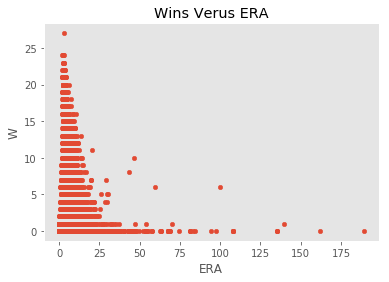

In [46]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
X1 = pitching[['ERA','W']].values
plt.scatter(X1[:, 0], X1[:, 1], s=20)
plt.xlabel('ERA'), plt.ylabel('W')
plt.grid()
plt.title('Wins Verus ERA')
plt.show()

In [50]:
import seaborn as sns
sns.regplot(pitching['yearID'],pitching['ERA'])


KeyError: 'yearID'